> ## 1. Building a Character Tokenizer

> ### 1.1. Taking a look at the data

In [10]:
with open("input.txt", 'r', encoding='utf-8') as file:
    text = file.read()
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"We have {vocab_size} unique characters in our vocabulary")

We have 65 unique characters in our vocabulary


> ### 1.2.  Encoder and Decoder (basic)

In [9]:
encoder = {ch:idx for idx, ch in enumerate(chars)}
decoder = {idx:ch for idx, ch in enumerate(chars)}

encode = lambda s: [encoder[c] for c in s]
decode = lambda l: ''.join([decoder[i] for i in l])

In [11]:
data = torch.tensor(encode(text), dtype=torch.long)

print(f"Shape of data: {data.shape}")
print(f"Datatype of tensor: {data.dtype}")

n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

Shape of data: torch.Size([1115394])
Datatype of tensor: torch.int64


> ### 1.3. Setting the ground

> #### 1.3.1. Hyperparameters

In [36]:
batch_size = 16
block_size = 32

max_iter = 2400
eval_iters = 200
eval_interval = 100

learning_rate = 1e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

> #### 1.3.2. Generating batches

+ The `get_batch()` function
    + gets hold of the data
    + generates  `batch_size` number of offsets
    + generates a block from each offset 
    + generates a shifted block from each offset 
    + stacks these block into rows (each row is independent)

In [26]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    
    random_offsets = torch.randint(low=0, high=len(data) - block_size,
                                   size=(batch_size, ))
    
    x = torch.stack([data[idx:idx+block_size] for idx in random_offsets]).to(device)    
    y = torch.stack([data[idx+1:idx+block_size+1] for idx in random_offsets]).to(device)
    return x, y

> ## 2. Implementing Self-Attention

> ### 2.1. Single Head Attention

+ Shape of `query`: (`batch_size`, `block_size`, `head_size`)
+ Shape of `key`: (`batch_size`, `block_size`, `head_size`)
+ Shape of `key.transpose(-2, -1)`: (`batch_size`, `head_size`, `block_size`)
<br><br>
+ Multiplication of `q` and `k.transpose(-2, -1)` (ignoring the batch dimension):
    + (`block_size`, `head_size`) . (`head_size`, `block_size`)
    + The multiplication will give the output of shape: (`block_size`, `block_size`) or (`T`, `T`) 
<br><br>    
+ Multiplication of $\text{q} \ . \ \text{k}^\top$ and `v` (ignoring the batch dimension):
    + (`block_size`, `block_size`) . (`block_size`, `head_size`)
    + The multiplication will give the output of shape: (`block_size`, `head_size`)
<br><br>

+ **NOTE:**
    + `T` is used interchangeably with `block_size`
    + `C` is used interchangeably with `n_embed`
    + `head_size` denotes `n_embed` ÷ `n_head`

In [27]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):        
        B, T, C = x.shape

        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        
        wei = q @ k.transpose(-2, -1) * C ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        out = wei @ v
        return out

> ### 2.2. Multi Head Attention

In [28]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out 

In [29]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),                
            nn.Linear(n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        out = self.net(x)
        return out

> ### 2.4. Transformer Block Implementation

In [30]:
class Block(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()

        self.sa = MultiHeadAttention(num_heads=n_head, head_size=(n_embd // n_heads))
        self.ffwd = FeedForward(n_embd=n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = self.ln1(x)
        x = x + self.sa(x)
        x = self.ln2(x)
        x = x + self.ffwd(x)        
        return x

> ## 3. Language Model Implementation

+ Key Components
    + Token Embedding Table (`token_embedding_table`)
    <br><br>
    + Position Embedding Table (`position_embedding_table`)
    <br><br>
    + Transformer Blocks (`blocks`)
        + A sequence of transformer blocks defined by the Block class. Each block applies multi-head self-attention and feed-forward networks, allowing the model to learn complex relationships between tokens.
        <br><br>
    + Layer Normalization (`ln_f`)
    <br><br>
    + Output Linear Layer (lm_head)
    <br><br>

In [31]:
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.token_emebdding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd=n_embd, n_heads=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_embd = self.token_emebdding_table(idx)
        pos_embd = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_embd + pos_embd
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):            
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)  
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx =  torch.cat((idx, idx_next), dim=1)

        return idx

> ## 5. Training and Evaluating Loops
+ The `estimate_loss` function estimates the average loss on the training and validation splits without computing gradients (using `torch.no_grad( )` to save memory and computation) and returns a dictionary containing the mean losses for both splits.
<br><br>
<br><br>

> #### Training Loop
+ The training loop loops through a defined number of iterations (`max_iter`).
<br><br>
+ At every `eval_interval` iterations or at the last iteration, it estimates the loss using `estimate_loss( )` and prints the average training and validation losses.
+ It works by:
    + Sampling a batch of training data using `get_batch('train')`.
    + Computing the logits and loss from the model.
    + Resetting the gradients with `optimizer.zero_grad(set_to_none=True)`.
    + Performing backpropagation with `loss.backward( )`.
    + Updating the model parameters `with optimizer.step( )`.
<br><br>
<br><br>

> #### Generating New Tokens
+ It works by:
    + Initializing a context tensor of zeros, which acts as the starting input for the model.
    + Calling the `generate( )` method of the model to produce `max_new_tokens`.
    + Decoding the generated token indices into human-readable text using `decode( )`.

In [41]:
model = LanguageModel()
m = model.to(device=device)
num_of_model_parameters = sum(p.numel() for p in m.parameters())/1e6
print(f"The model has {num_of_model_parameters}" , 'M parameters')

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

tr_losses = []
val_losses = []
def train():
    for iter in range(max_iter):
        if iter % eval_interval == 0 or iter == max_iter - 1:
            losses = estimate_loss()
            tr_losses.append(losses['train'])
            val_losses.append(losses['val'])
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        
        xb, yb = get_batch('train')
        
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

The model has 0.110657 M parameters


In [42]:
train()

step 0: train loss 4.4385, val loss 4.4463
step 100: train loss 2.7379, val loss 2.7659
step 200: train loss 2.5446, val loss 2.5549
step 300: train loss 2.4586, val loss 2.4789
step 400: train loss 2.3923, val loss 2.4095
step 500: train loss 2.3482, val loss 2.3658
step 600: train loss 2.3119, val loss 2.3250
step 700: train loss 2.2716, val loss 2.2815
step 800: train loss 2.2339, val loss 2.2526
step 900: train loss 2.1985, val loss 2.2188
step 1000: train loss 2.1713, val loss 2.2066
step 1100: train loss 2.1320, val loss 2.1647
step 1200: train loss 2.1257, val loss 2.1478
step 1300: train loss 2.0987, val loss 2.1366
step 1400: train loss 2.0727, val loss 2.1235
step 1500: train loss 2.0494, val loss 2.1004
step 1600: train loss 2.0206, val loss 2.0873
step 1700: train loss 2.0184, val loss 2.0848
step 1800: train loss 1.9983, val loss 2.0624
step 1900: train loss 1.9921, val loss 2.0637
step 2000: train loss 1.9713, val loss 2.0526
step 2100: train loss 1.9553, val loss 2.0261


> ### 5.1. Plotting loss curves

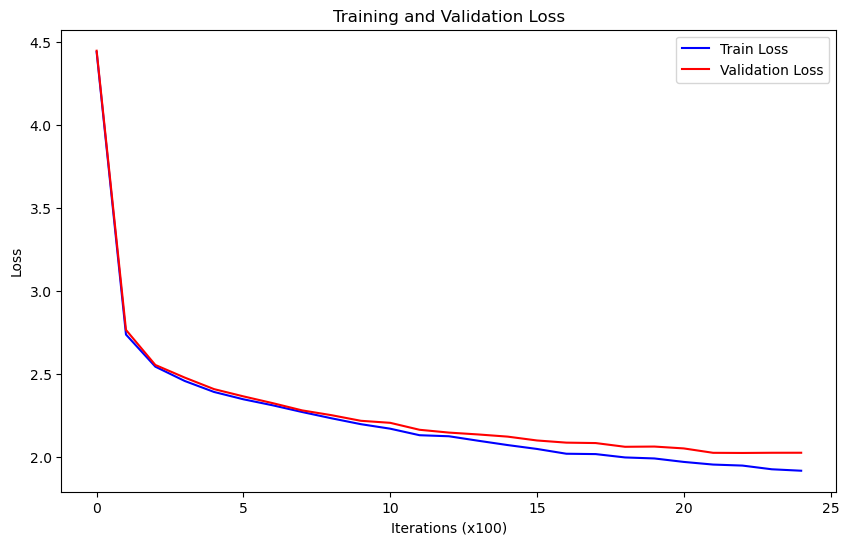

In [43]:
import matplotlib.pyplot as plt
def plot_losses():    
    plt.figure(figsize=(10, 6))    
    plt.plot(range(len(tr_losses)), tr_losses, label='Train Loss', color='blue')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Iterations (x100)')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_losses()

In [44]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


Your ways, so affam, this ofor Aughors, am to thee;
Awary to: ay? busink'd feet!

Ning ELrows! my too his a brove, Eersthings,-mained doo belless:
Ghird grot pote arst your somele,
Nour bayw hiapker'q'eees eyitain them and castluce inbjuloke agonsty that.

Sourds your deassher toffuliks not forjed your
For ains tries igon the is getsaed falst orey lovind

That deages.


QUEEEN EOFored EDborg And Carplien ding for slon your to hath
s. May uters as and allows, the grield of and Gomodly Cay Cose is


> ## 6. Byte Pair Encoding (BPE) Implementation

In [47]:
def decode_ids_to_string(ids_list):
    return b"".join(byte_map[i] for i in ids_list).decode('utf-8', errors='replace')

In [70]:
class BPE:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.num_merges = self.vocab_size - 256
    
    @staticmethod
    def get_pair_counts_dict(utf_ids):
        counts = {}
        for pair in zip(utf_ids, utf_ids[1:]):
            counts[pair] = counts.get(pair, 0) + 1
        return counts
    
    @staticmethod
    def merge_and_replace_pairs(utf_ids, pair, new_id=256):
        new_utf_ids = []
        i = 0
        while i < len(utf_ids):
            if i < len(utf_ids) - 1 and utf_ids[i] == pair[0] and utf_ids[i+1] == pair[1]:
                new_utf_ids.append(new_id)
                i += 2
            else:
                new_utf_ids.append(utf_ids[i])
                i += 1
        return new_utf_ids
        
    def fit(self, text):
        utf_ids = text.encode('utf-8')
        utf_ids = list(map(int, utf_ids))
        new_utf_ids = utf_ids.copy()
        merges_map = {}

        for i in range(num_merges):
            pair_counts_dict = get_pair_counts_dict(new_utf_ids)
            max_count_pair = max(pair_counts_dict, key=pair_counts_dict.get)
            new_id = 256 + i
            new_utf_ids = merge_and_replace_pairs(new_utf_ids, max_count_pair, new_id)
            merges_map[max_count_pair] = new_id
        byte_map = {old_id: bytes([old_id]) for old_id in range(256)}
        for ((id_1, id_2), new_id) in merges_map.items():
            byte_map[new_id] = byte_map[id_1] + byte_map[id_2]

    def encode(self, text):
        utf_ids = list(text.encode('utf-8'))    
        while len(utf_ids) >= 2:
            pair_counts_dict = get_pair_counts_dict(utf_ids)
            pair = min(pair_counts_dict, key=lambda p: merges_map.get(p, float('inf')))
            if pair not in merges_map:
                break
            utf_id = merges_map[pair]
            utf_ids = merge_and_replace_pairs(utf_ids, pair, utf_id)
        return utf_ids

    def decode(self, encoded):
        return b"".join(byte_map[i] for i in encoded).decode('utf-8', errors='replace')

In [62]:
bpe = BPE(vocab_size=5000)
data = torch.tensor(bpe.encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

> ### 6.1. Modify the GPT Head to Use RoPE

In [103]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
        
        dim = head_size // 2
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, dtype=torch.float32) / dim))

        pos = torch.arange(0, block_size, dtype=torch.float32).unsqueeze(1)
        angles = pos * inv_freq
        
        self.register_buffer('cos', torch.cos(angles))
        self.register_buffer('sin', torch.sin(angles))
        
    def apply_rope(self, q, k, seq_len):
        cos = self.cos[:seq_len, :].unsqueeze(0)
        sin = self.sin[:seq_len, :].unsqueeze(0)
        
        q1, q2 = torch.chunk(q, 2, dim=-1)
        k1, k2 = torch.chunk(k, 2, dim=-1)
        
        q_rot = torch.cat([q1 * cos - q2 * sin, q1 * sin + q2 * cos], dim=-1)
        k_rot = torch.cat([k1 * cos - k2 * sin, k1 * sin + k2 * cos], dim=-1)

        return q_rot, k_rot
    
    def forward(self, x):
        B, T, C = x.shape
        
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        
        wei = q @ k.transpose(-2, -1) * C ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        out = wei @ v
        return out
    
class FeedForward(nn.Module):
    def __init__(self, n_embd):        
        super().__init__()
        self.w1 = nn.Linear(n_embd, n_embd)
        self.w2 = nn.Linear(n_embd, n_embd)
        self.w3 = nn.Linear(n_embd, n_embd)

    def forward(self, x):
        z = self.w1(x)
        swish_z = z * torch.sigmoid(z)        
        g = self.w3(x)        
        gated_output = swish_z * g        
        out = self.w2(gated_output)
        return out
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out 

class Block(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.sa = MultiHeadAttention(num_heads=n_heads, head_size=(n_embd // n_heads))
        self.ffwd = FeedForward(n_embd=n_embd)
        self.ln1 = nn.RMSNorm(n_embd, eps=1e-8)
        self.ln2 = nn.RMSNorm(n_embd, eps=1e-8)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_emebdding_table = nn.Embedding(vocab_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd=n_embd, n_heads=n_head) for _ in range(n_layer)])
        self.ln_f = nn.RMSNorm(n_embd, eps=1e-8)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B,T = idx.shape
        tok_embd = self.token_emebdding_table(idx)
        x = tok_embd
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets == None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

#     def generate(self, idx, max_new_tokens):
#         """
#         Generate new tokens based on the input index tensor.

#         Parameters:
#         - idx: Tensor of shape (B, T) where B is the batch size and T is the sequence length.
#         - max_new_tokens: Maximum number of new tokens to generate.

#         Returns:
#         - idx: Tensor containing the original indices and the newly generated tokens.
#         """

#         # TODO: Implement the generate method.
#         # You need to:
#         # 1. Loop for the number of tokens to generate (max_new_tokens).
#         # 2. Take the last 'block_size' tokens from idx as context.
#         # 3. Pass this context to the model to get logits.
#         # 4. Extract the logits corresponding to the last token in the sequence.
#         # 5. Convert the logits to probabilities using softmax.
#         # 6. Sample from the probabilities to get the next token index.
#         # 7. Concatenate the new token index to the original idx tensor.

#         for _ in range(max_new_tokens):
#             # TODO: Implement steps here to generate new tokens
#             idx_cond = ...  # Get the last 'block_size' tokens
#             logits, loss = self(idx_cond)  # Forward pass to get logits
#             logits = ...  # Extract logits for the last token
#             probs = ...  # Convert logits to probabilities
#             idx_next = ...  # Sample from the distribution
#             idx = ...  # Concatenate new token to idx

#         return idx  # Return the tensor containing original indices and newly generated tokens    

In [104]:
model = LanguageModel()
m = model.to(device=device)

AttributeError: module 'torch.nn' has no attribute 'RMSNorm'

In [108]:
import torch.nn as nn
try:
    rmsnorm_layer = nn.RMSNorm(256)
    print("RMSNorm is working!")
except AttributeError as e:
    print("Error:", e)

Error: module 'torch.nn' has no attribute 'RMSNorm'
